In [1]:
from __future__ import division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
np.random.seed(42)
from utils import datagen, plotting
import coresets
import algorithms
from keras.datasets import mnist

/home/nerdking/env2/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
/home/nerdking/env2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nerdking/env2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_

In [2]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import random
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from itertools import chain
from collections import Counter

In [3]:
###MNIST

### Small dataset
# X_train = np.load('./dataset/new_train_x.npy')
# Y_train = np.load('./dataset/new_train_y.npy')
# X_test = np.load('./dataset/new_test_x.npy')
# Y_test = np.load('./dataset/new_test_y.npy')
# print(X_train.shape, Y_train.shape);print(X_test.shape, Y_test.shape)


(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.reshape((-1, 784)).astype('float32') / 255.0
X_test = X_test.reshape((-1, 784)).astype('float32') / 255.0
# y_train = to_categorical(y_train, 10)
# y_test = to_categorical(y_test, 10)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)




### Latent space dataset
latent_space_train = np.load('./dataset/MNIST_train_latent_space_z7.npy')
print(latent_space_train.shape, Y_train.shape)

latent_space_test = np.load('./dataset/MNIST_test_latent_space_z7.npy')
print(latent_space_test.shape, Y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)
(60000, 7) (60000,)
(10000, 7) (10000,)


In [4]:
tuned_parameters = [{'kernel': ['rbf'], 'C' : [0.1, 1, 10, 100]},
                    {'kernel': ['linear'], 'C' : [0.1, 1, 10, 100]}]
score = 'accuracy'
clf = GridSearchCV(SVC(), tuned_parameters, scoring=score, n_jobs=-1)

In [5]:
coreset_size = 1500 #20000 #
coreset_size

1500

In [6]:
km_coreset_gen = coresets.KMeansCoreset(latent_space_train)

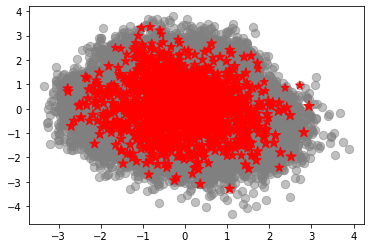

In [7]:
C1, w1 = km_coreset_gen.generate_coreset(coreset_size)
plotting.plot_2d_points_and_coreset(latent_space_train, C1, w1)

In [8]:
y_ind = []
new_y_train = []
for i in C1:
    result = np.where(latent_space_train==i)[0][1]
    y_ind.append(result)
    new_y_train.append(Y_train[result])

In [9]:
len(y_ind)

1500

In [10]:
for i in range(len(y_ind)):
    #print(i)
    np.testing.assert_array_equal(latent_space_train[y_ind[i]],C1[i])

In [11]:
new_y = np.array(new_y_train)

# Active Learning

# Random points K=50

In [ ]:
mean_random = []
sd_random = []

for coreset_size in range(50,501,50): # start from 50 labeled points
# for coreset_size in range(1000,9001,1000): # start from 50 labeled points
    print("*********************** Training on {} points ***********************".format(coreset_size))
    accuracy = [] # calculate accuracy of 100 iterations
    c = list(zip(C1,new_y))
    iterations = 0
    while iterations < 100: # run 100 simulations and take average 
        train_data = []
        train_labels = []
        for (data,label) in random.sample(c,coreset_size):
            train_data.append(data)
            train_labels.append(label)  
        train_x = np.array(train_data)
        train_y = np.array(train_labels)
        
        print()
        print("Distribution of data in the training points")
        print(Counter(train_y)) 

        clf.fit(train_x, train_y)
        print("Best parameters set found on {} data points:".format(coreset_size))
        print(clf.best_params_)
        print()
        y_true, y_pred = Y_test, clf.predict(latent_space_test)
        accuracy.append(accuracy_score(y_true, y_pred))
        iterations += 1
    accuracy = np.asarray(accuracy)
    mean_accuracy = accuracy.mean()
    sd_accuracy = accuracy.std()
    
    mean_random.append(mean_accuracy)
    sd_random.append(sd_accuracy)

In [ ]:
mean_accuracy_coreset = np.array(mean_accuracy_coreset)
sd_accuracy_coreset = np.array(sd_accuracy_coreset)

In [ ]:
np.save('./result/mean_accuracy_sensitivity_cs1000_MNIST_z7_K50.npy',mean_accuracy_coreset)
np.save('./result/sd_accuracy_sensitivity_cs1000_MNIST_z7_K50.npy',sd_accuracy_coreset)